# Importing libraries

In [15]:
import pandas as pd
from typing import List,Tuple
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
import os
print(os.getcwd())

c:\Users\andre\OneDrive\Desktop\AI_ML projects\Loan Default Prediction


# Read the data

In [17]:
loan_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")
print(f"The dataframe has shape {loan_df.shape}")
print(list(loan_df.columns))

C:\Users\andre\AppData\Local\Temp\ipykernel_15948\1006134747.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")


The dataframe has shape (2260701, 151)
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verifi

Compute numeric data from dates of issue and earliest credit line 

In [18]:
def compute_months(df:pd.DataFrame, date1:str, date2:str) -> pd.Series:
    d1 = pd.to_datetime(df[date1], format = "%b-%Y", errors="coerce")
    d2 = pd.to_datetime(df[date2], format = "%b-%Y", errors = "coerce")
    diff = (d1.dt.year - d2.dt.year) * 12 + (d1.dt.month - d2.dt.month)
    return diff

loan_df["months_since_earliest_cr"] = compute_months(loan_df, "issue_d", "earliest_cr_line")

- Remove columns that are missing 70% or more. Check categorical and numerical cols remaining
- Remove columns that leak information in the future as our business goal is to determine whether a loan should be accepted or rejected,
once issued without prior knowledge of payments

In [19]:
def missing_thresh_cols(df:pd.DataFrame, threshold : float = 0.7) -> List:
    if not (0.0 <= threshold <= 1.0):
        raise ValueError("Invalid threshold. Must be between 0 and 1")
    return df.columns[df.isna().mean() >= 0.7]

missing_cols = list(missing_thresh_cols(loan_df))

# look-forward columns
lf_columns = ['last_pymnt_d','next_pymnt_d', 'hardship_flag', 'disbursement_method',
               'debt_settlement_flag', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
              'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
              'collection_recovery_fee', 'last_pymnt_amnt', 'last_credit_pull_d',
              'last_fico_range_high', 'last_fico_range_low']

extra_columns_to_remove = [col for col in loan_df.columns if col.startswith("hardship") or "settlement" in col] + ["id", "emp_title", "issue_d", "url", "title", "zip_code", "policy_code"]

loan_df = loan_df.drop(columns = missing_cols + lf_columns + extra_columns_to_remove)
categorical_cols = loan_df.select_dtypes(["object","category"]).columns
print(f"Categorical columns: {categorical_cols}")
numerical_cols = loan_df.select_dtypes(["float64", "int64"]).columns
print(f"Numerical columns: {numerical_cols}")


Categorical columns: Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'pymnt_plan', 'purpose',
       'addr_state', 'earliest_cr_line', 'initial_list_status',
       'application_type'],
      dtype='object')
Numerical columns: Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'ch

Mapping categorical variables

In [20]:
state_to_region = {
    'CA': 'West', 'OR': 'West', 'UT': 'West', 'WA': 'West', 'CO': 'West',
    'NV': 'West', 'AK': 'West', 'MT': 'West', 'HI': 'West', 'WY': 'West', 'ID': 'West',
    'AZ': 'SouthWest', 'TX': 'SouthWest', 'NM': 'SouthWest', 'OK': 'SouthWest',
    'GA': 'SouthEast', 'NC': 'SouthEast', 'VA': 'SouthEast', 'FL': 'SouthEast', 'KY': 'SouthEast',
    'SC': 'SouthEast', 'LA': 'SouthEast', 'AL': 'SouthEast', 'WV': 'SouthEast', 'DC': 'SouthEast',
    'AR': 'SouthEast', 'DE': 'SouthEast', 'MS': 'SouthEast', 'TN': 'SouthEast',
    'IL': 'MidWest', 'MO': 'MidWest', 'MN': 'MidWest', 'OH': 'MidWest', 'WI': 'MidWest',
    'KS': 'MidWest', 'MI': 'MidWest', 'SD': 'MidWest', 'IA': 'MidWest', 'NE': 'MidWest',
    'IN': 'MidWest', 'ND': 'MidWest',
    'CT': 'NorthEast', 'NY': 'NorthEast', 'PA': 'NorthEast', 'NJ': 'NorthEast', 'RI': 'NorthEast',
    'MA': 'NorthEast', 'MD': 'NorthEast', 'VT': 'NorthEast', 'NH': 'NorthEast', 'ME': 'NorthEast'
}

loan_df["state"] = loan_df["addr_state"].map(state_to_region)

sub_grade_to_risk = {}
letters = "ABCDEFG"
numbers ="12345"
i = 1
for letter in letters:
    for number in numbers:
        sub_grade_to_risk[letter+number] = i
        i += 1

loan_df["risk_grade"] = loan_df["sub_grade"].map(sub_grade_to_risk)

emp_length_to_int = {'10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0.5,
    'n/a': 0
}

loan_df["emp_length_int"] = loan_df["emp_length"].map(emp_length_to_int)

# Remove columns that have been processed from the dataframe
loan_df = loan_df.drop(columns=["grade", "sub_grade", "emp_length", "addr_state", "earliest_cr_line"])

View unique classes for each categorical variable remaining

In [21]:
def view_categorical_types(df:pd.DataFrame) -> None:
    for col in df.select_dtypes(["object"]).columns:
        print(f"{col} : {df[col].unique()}")

view_categorical_types(loan_df)

term : [' 36 months' ' 60 months' nan]
home_ownership : ['MORTGAGE' 'RENT' 'OWN' 'ANY' nan 'NONE' 'OTHER']
verification_status : ['Not Verified' 'Source Verified' 'Verified' nan]
loan_status : ['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default' nan
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']
pymnt_plan : ['n' 'y' nan]
purpose : ['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational' nan]
initial_list_status : ['w' 'f' nan]
application_type : ['Individual' 'Joint App' nan]
state : ['NorthEast' 'MidWest' 'SouthEast' 'SouthWest' 'West' nan]


Modify the loan status into a binary class
- Good Loans: 'Fully Paid' 'Does not pass the credit policy. Status:Fully Paid'
- Bad Loans : 'Charged Off' 'In Grace Period' 'Late (31-120 days)' 'Late (16-30 days)' 'Default' 
  'Does not meet the credit policy. Status:Charged Off'

Note: Current and Issued Loans do not show direction so they are excluded
Case of Imbalanced Classes

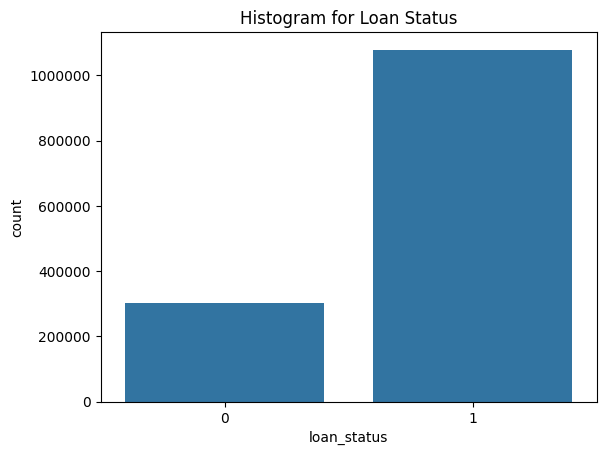

In [22]:
def modify_target_binary(df:pd.DataFrame, target:str) -> pd.DataFrame:
    df = df.loc[~df[target].isin(["Current","Issued"])].copy()
    good_statuses = ["Fully Paid",
                   'Does not meet the credit policy. Status:Fully Paid']
    df[target] = df[target].isin(good_statuses).astype(int)
    return df

loan_df = modify_target_binary(loan_df, "loan_status")

def plot_target_histogram(df:pd.DataFrame, target:str):
    ax = sns.countplot(data=df, x=target)
    ax.ticklabel_format(style='plain', axis='y') 
    ax.set_title("Histogram for Loan Status") 
    plt.show()

plot_target_histogram(loan_df, "loan_status")
 

View histograms of numerical features to decide imputation technique

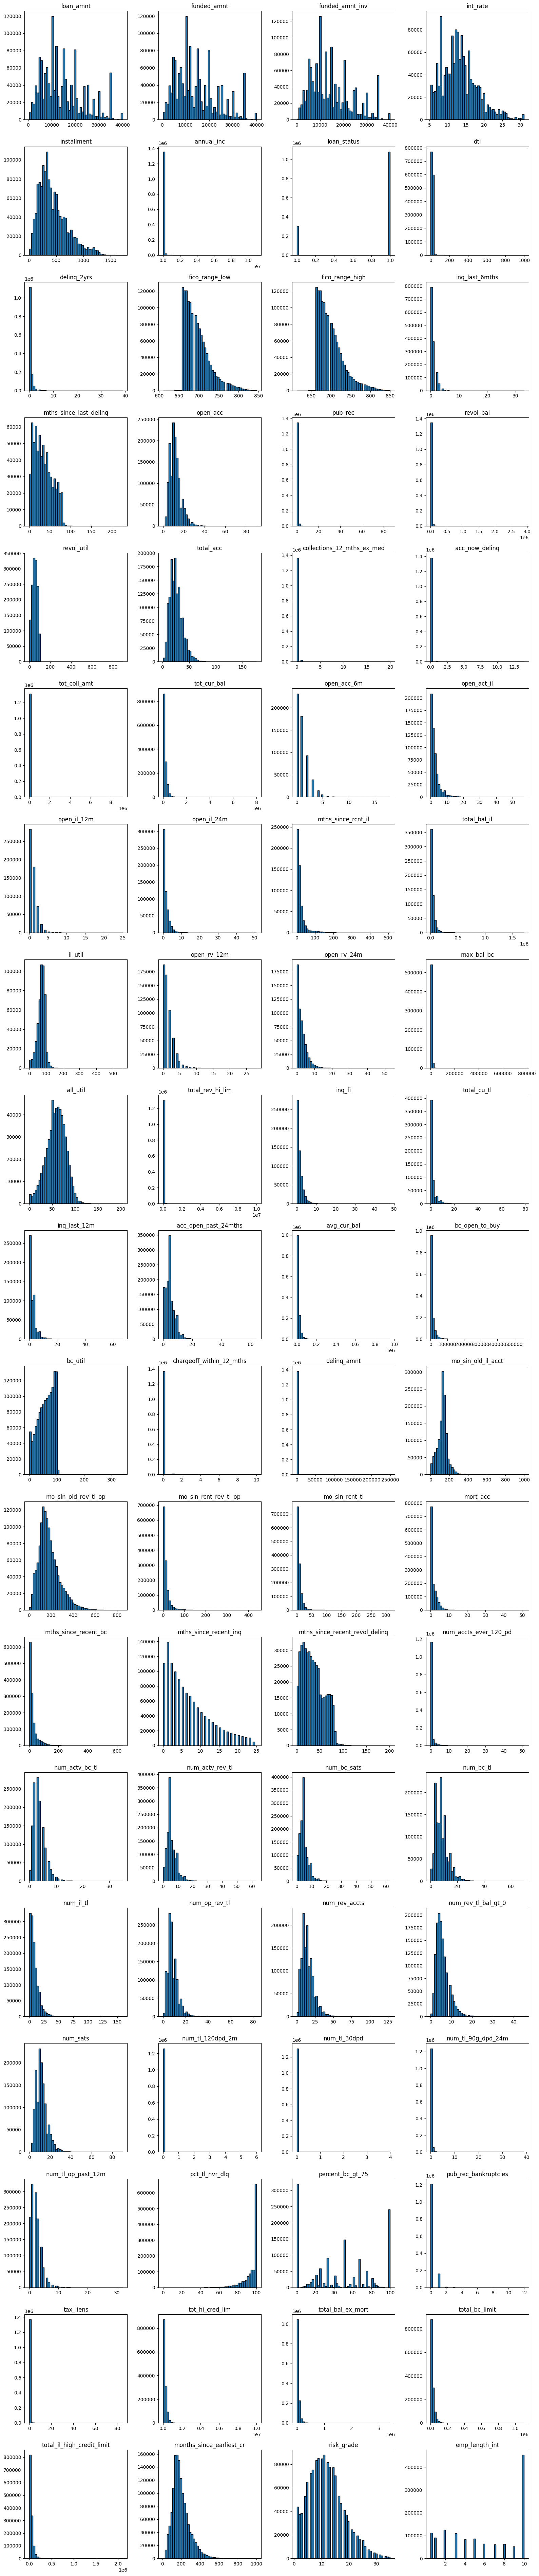

In [23]:
def plot_feature_histograms(df:pd.DataFrame):
    cols = df.select_dtypes(["int64","float64"]).columns  
    n = len(cols)

    rows = (n + 3) // 4      # 4 plots per row
    fig, axes = plt.subplots(rows, 4, figsize=(16, 4*rows))

    axes = axes.flatten()

    for i, col in enumerate(cols):
        axes[i].hist(df[col].dropna(), bins=50, edgecolor= 'black')
        axes[i].set_title(col)


    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_feature_histograms(loan_df)

Pearson Correlation and Spearman Correlation of numerical features with target

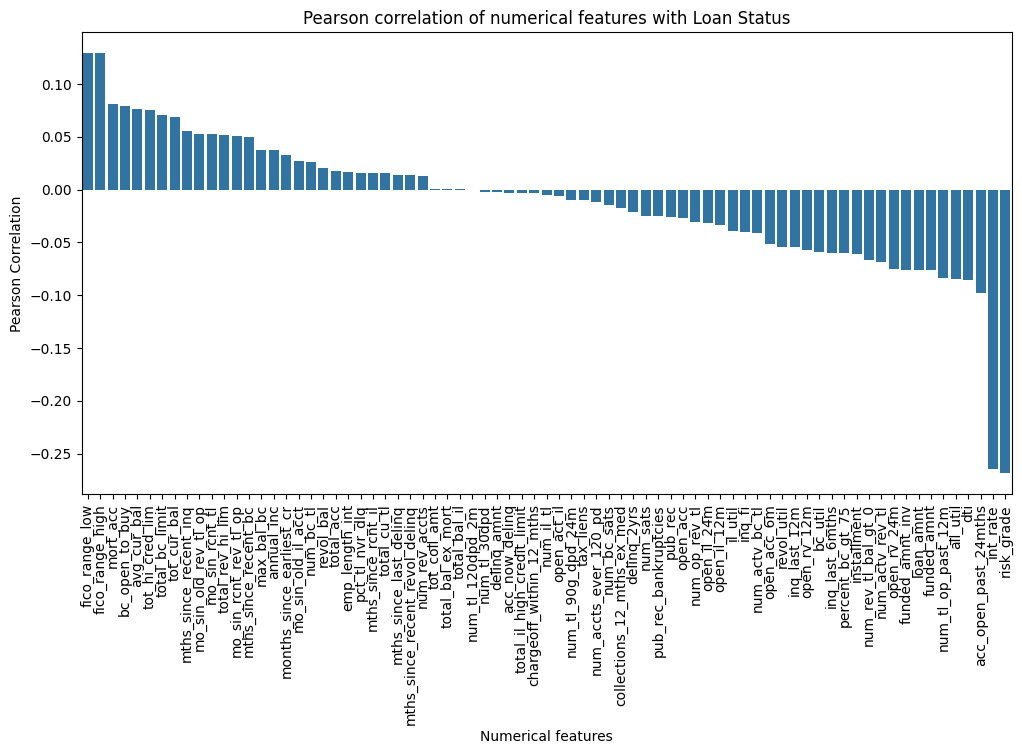

In [24]:
def plot_pearson_correlation(df:pd.DataFrame, target:str) -> None:
    corr_matrix = df.select_dtypes(["int64", "float64"]).corr(method="pearson")[target]
    corr_matrix = corr_matrix.drop(target).sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    sns.barplot(x = corr_matrix.index, y = corr_matrix, orient = 'v')
    plt.xlabel("Numerical features")
    plt.ylabel("Pearson Correlation")
    plt.title("Pearson correlation of numerical features with Loan Status")
    plt.xticks(rotation = 90)
    plt.show()


plot_pearson_correlation(loan_df, "loan_status")
